In [3]:
# Ячейка 1: Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import LabelEncoder

# Настройка стиля графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)# размер графиков

print("Библиотеки успешно загружены.")

Библиотеки успешно загружены.


In [ ]:
# Ячейка 2: Загрузка данных
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
file_path = "statlog+german+credit+data/german.data"


# Имена столбцов (Attributes 1-20 + Class)
columns = [
    "checking_status", "duration", "credit_history", "purpose",
    "credit_amount", "savings", "employment", "installment_rate",
    "personal_status", "other_debtors", "residence_since",
    "property", "age", "other_installment_plans", "housing",
    "existing_credits", "job", "liable_people", "telephone",
    "foreign_worker", "class"
]

# Загрузка (разделитель - пробел)
try:
    df = pd.read_csv(file_path, sep=' ', names=columns, header=None)
    print("Данные успешно загружены из файла.")
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {file_path}. Проверь имя папки.")

print(f"Размер датасета: {df.shape}")
df.head()

Данные успешно загружены из локального файла.
Размер датасета: (1000, 21)


,checking_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,liable_people,telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
# Ячейка 3: Создание словарей для декодирования

# Attribute 1: Checking Status
map_checking = {
    'A11': '< 0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '>= 200 DM',
    'A14': 'No checking account'
}

# Attribute 3: Credit History
map_history = {
    'A30': 'No credits/Paid back',
    'A31': 'All paid back (this bank)',
    'A32': 'Existing paid back',
    'A33': 'Delay in past',
    'A34': 'Critical account'
}

# Attribute 4: Purpose
map_purpose = {
    'A40': 'Car (new)', 'A41': 'Car (used)',
    'A42': 'Furniture/Equip', 'A43': 'Radio/TV',
    'A44': 'Domestic appliances', 'A45': 'Repairs',
    'A46': 'Education', 'A48': 'Retraining',
    'A49': 'Business', 'A410': 'Others'
}

# Attribute 6: Savings
map_savings = {
    'A61': '< 100 DM', 'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM', 'A64': '>= 1000 DM',
    'A65': 'Unknown/No savings'
}

# Class (Target): 1 = Good, 2 = Bad
map_class = {1: 'Good', 2: 'Bad'}

# Создаем "Читаемую" копию датафрейма для графиков
df_readable = df.copy()

# Применяем маппинг
df_readable['checking_status'] = df_readable['checking_status'].map(map_checking).fillna(df['checking_status'])
df_readable['credit_history'] = df_readable['credit_history'].map(map_history).fillna(df['credit_history'])
df_readable['purpose'] = df_readable['purpose'].map(map_purpose).fillna(df['purpose'])
df_readable['savings'] = df_readable['savings'].map(map_savings).fillna(df['savings'])
df_readable['class_label'] = df_readable['class'].map(map_class)

print("Данные успешно декодированы. Пример:")
df_readable[['checking_status', 'purpose', 'credit_amount', 'class_label']].head()

Данные успешно декодированы. Пример:


,checking_status,purpose,credit_amount,class_label
0,< 0 DM,Radio/TV,1169,Good
1,0 <= ... < 200 DM,Radio/TV,5951,Bad
2,No checking account,Education,2096,Good
3,< 0 DM,Furniture/Equip,7882,Good
4,< 0 DM,Car (new),4870,Bad


In [4]:
# Ячейка 4: Описательная статистика и анализ рисков

# 1. Основные числовые характеристики
print("--- Статистика по числовым признакам ---")
display(df[['duration', 'credit_amount', 'age']].describe().round(2))

# 2. Баланс классов
risk_counts = df_readable['class_label'].value_counts()
print("\n--- Распределение целевого класса ---")
print(risk_counts)
print(f"Доля 'Bad' (рискованных) клиентов: {risk_counts['Bad'] / len(df) * 100:.1f}%")

# 3. Финансовая оценка риска (Cost Matrix Analysis)
# Выделим всех 'Bad' клиентов
bad_credits = df[df['class'] == 2]
total_exposure = bad_credits['credit_amount'].sum()
avg_bad_loan = bad_credits['credit_amount'].mean()

print("\n--- Финансовый анализ риска ---")
print(f"Общая сумма выданных 'плохих' кредитов: {total_exposure:,.0f} DM")
print(f"Средняя сумма дефолтного кредита: {avg_bad_loan:.2f} DM")
print("Учитывая матрицу стоимости (5:1), пропуск одного 'плохого' клиента")
print(f"эквивалентен потере прибыли от 5 'хороших' клиентов.")

--- Статистика по числовым признакам ---


,duration,credit_amount,age
count,1000.00,1000.00,1000.00
mean,20.90,3271.26,35.55
std,12.06,2822.74,11.38
min,4.00,250.00,19.00
25%,12.00,1365.50,27.00
50%,18.00,2319.50,33.00
75%,24.00,3972.25,42.00
max,72.00,18424.00,75.00



--- Распределение целевого класса ---
class_label
Good    700
Bad     300
Name: count, dtype: int64
Доля 'Bad' (рискованных) клиентов: 30.0%

--- Финансовый анализ риска ---
Общая сумма выданных 'плохих' кредитов: 1,181,438 DM
Средняя сумма дефолтного кредита: 3938.13 DM
Учитывая матрицу стоимости (5:1), пропуск одного 'плохого' клиента
эквивалентен потере прибыли от 5 'хороших' клиентов.


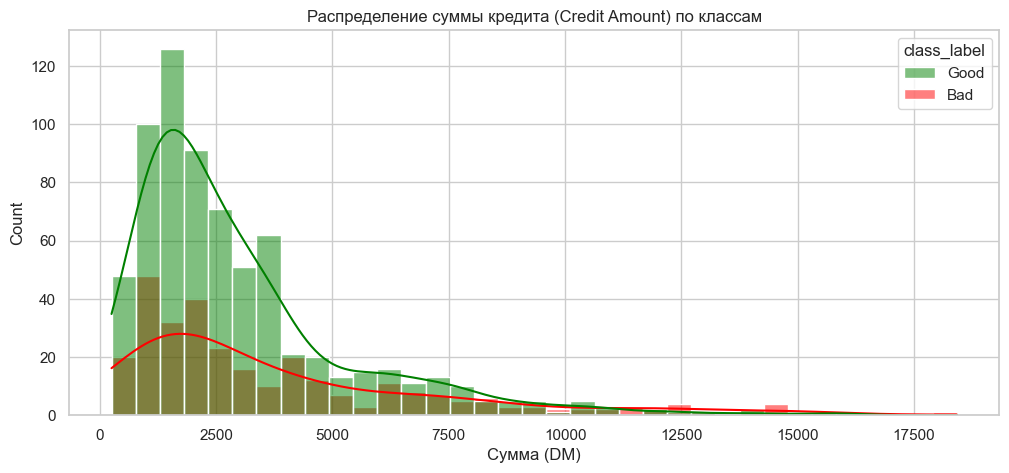

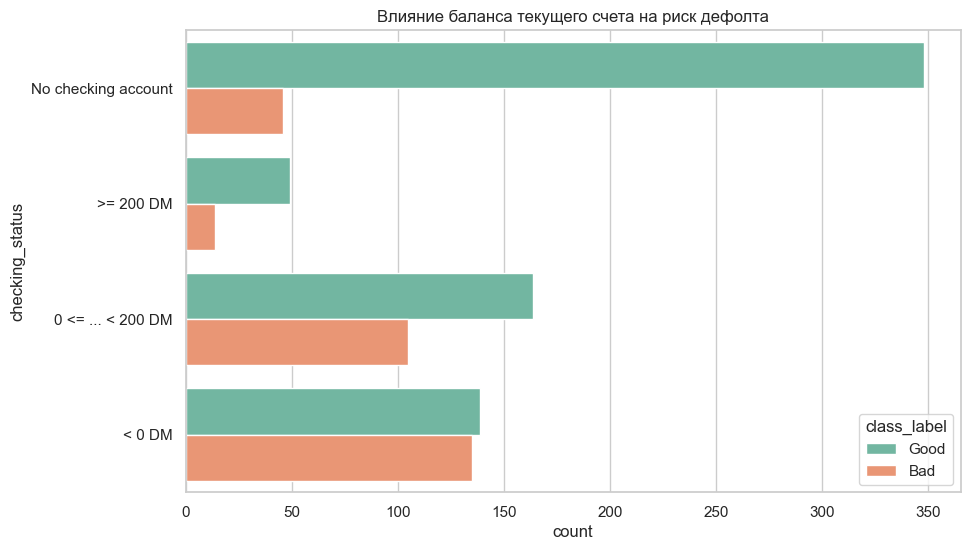

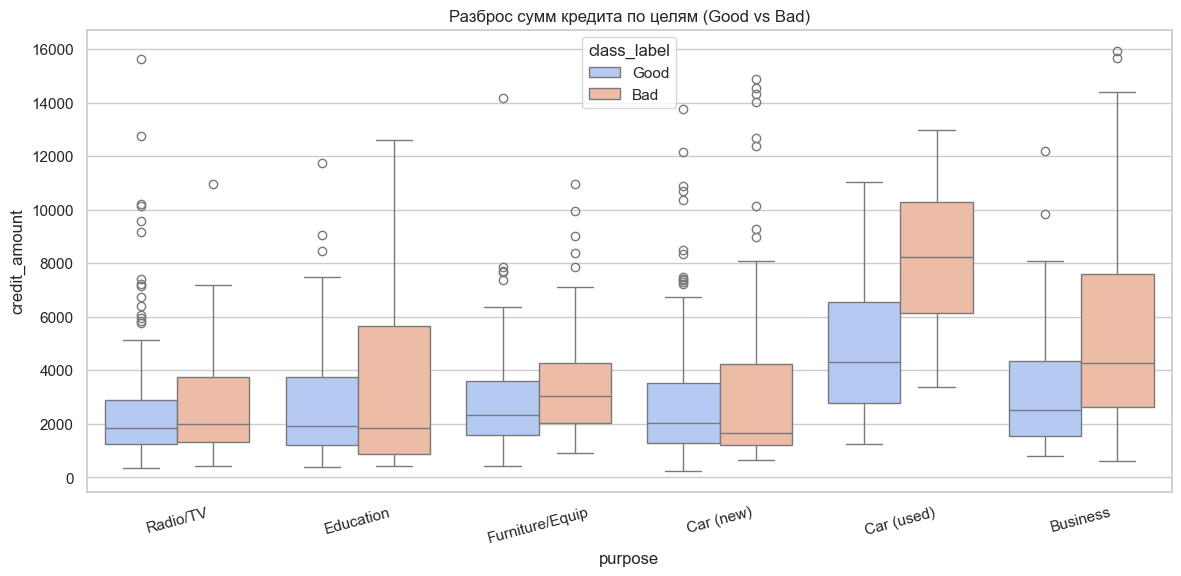

In [ ]:
# Ячейка 5: Визуализация

# График 1: Распределение суммы кредита (Гистограмма)
plt.figure(figsize=(12, 5))
sns.histplot(data=df_readable, x='credit_amount', hue='class_label', kde=True, palette={'Good': 'green', 'Bad': 'red'})
plt.title('Распределение суммы кредита (Credit Amount) по классам')
plt.xlabel('Сумма (DM)')
plt.show()

# График 2: Checking Status vs Risk (Ключевой фактор)
# Показывает зависимость надежности от состояния счета
plt.figure(figsize=(10, 6))
sns.countplot(y='checking_status', hue='class_label', data=df_readable,
              order=['No checking account', '>= 200 DM', '0 <= ... < 200 DM', '< 0 DM'],
              palette='Set2')
plt.title('Влияние баланса текущего счета на риск дефолта')
plt.show()

# График 3: Boxplot - Сумма кредита по Целям
plt.figure(figsize=(14, 6))
# Берем только самые популярные цели для чистоты графика
top_purposes = df_readable['purpose'].value_counts().nlargest(6).index
df_subset = df_readable[df_readable['purpose'].isin(top_purposes)]

sns.boxplot(x='purpose', y='credit_amount', hue='class_label', data=df_subset, palette='coolwarm')
plt.title('Разброс сумм кредита по целям (Good vs Bad)')
plt.xticks(rotation=15)
plt.show()

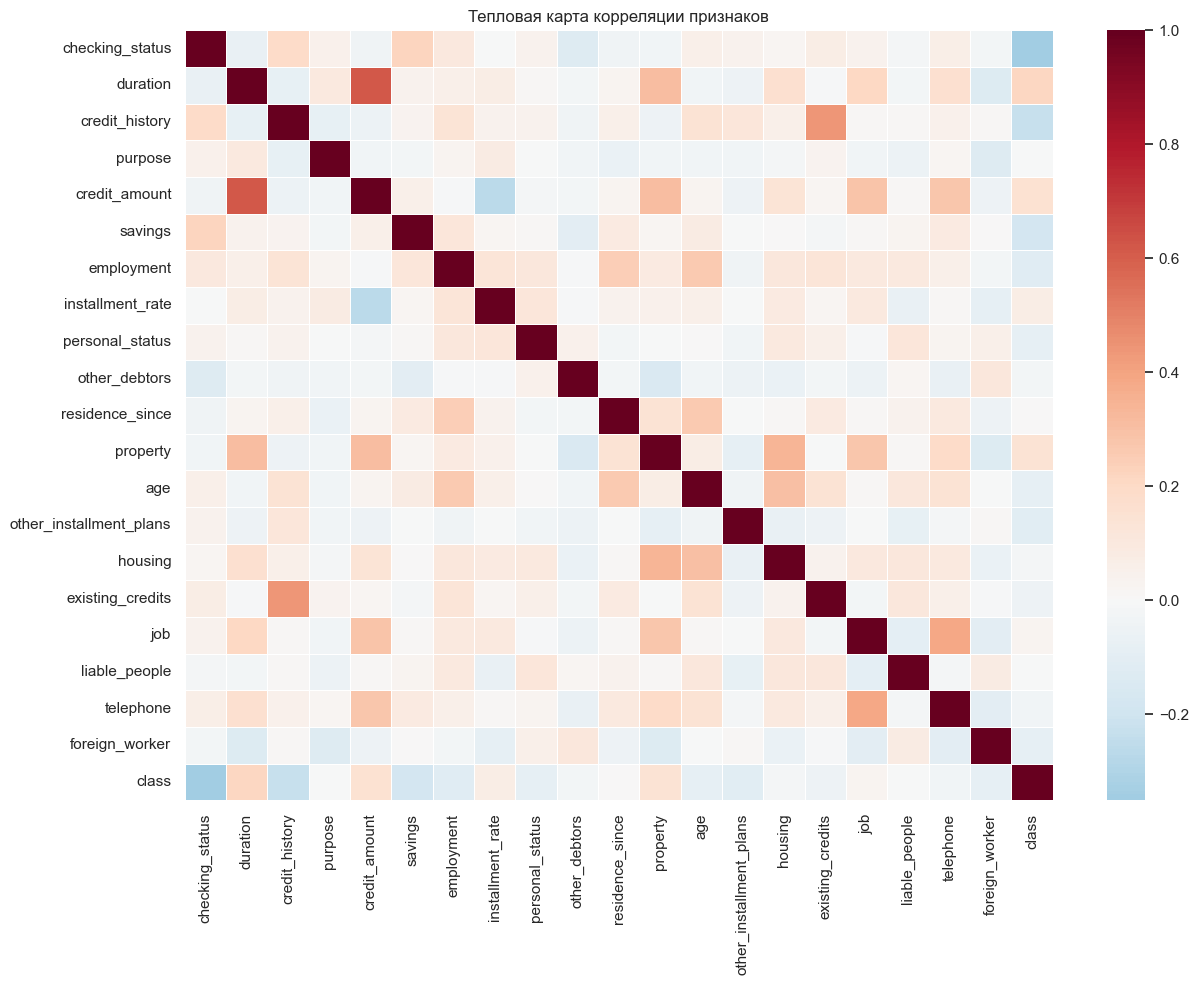

Топ-5 признаков, влияющих на класс (Risk):
class              1.000000
checking_status    0.350847
credit_history     0.228785
duration           0.214927
savings            0.178943
credit_amount      0.154739
Name: class, dtype: float64


In [6]:
# Ячейка 6: Кодирование и Матрица корреляций

# Копируем датафрейм
df_encoded = df.copy()
le = LabelEncoder()

# Находим колонки типа object (строковые коды Axx)
categorical_cols = df_encoded.select_dtypes(include=['object']).columns

# Кодируем их в числа (0, 1, 2...)
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Строим матрицу корреляций
plt.figure(figsize=(14, 10))
corr_matrix = df_encoded.corr()

# Рисуем Heatmap
sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0, linewidths=0.5)
plt.title('Тепловая карта корреляции признаков')
plt.show()

# Топ-5 признаков, коррелирующих с Class (Risk)
print("Топ-5 признаков, влияющих на класс (Risk):")
# Сортируем по модулю корреляции (чем больше по модулю, тем сильнее связь)
print(corr_matrix['class'].abs().sort_values(ascending=False).head(6))

In [ ]:
# Ячейка 7: Работа с SQL (Финальный этап)

# 1. Подключение и создание таблицы
conn = sqlite3.connect('german_credit.db')
cursor = conn.cursor()

# Подготовим данные для SQL
# Переименуем 'class_label' в 'risk_status' для понятности в SQL
# И уберем технические столбцы, если нужно, но пока оставим всё
df_sql = df_readable.rename(columns={'class_label': 'risk_status'})

# Записываем dataframe в базу данных (если таблица есть - перезапишем)
df_sql.to_sql('credits', conn, if_exists='replace', index=False)
print("Таблица 'credits' успешно создана в файле 'german_credit.db'.")

# ---------------------------------------------------------
# ЗАПРОС 1: Агрегация по целям (Бизнес-аналитика)
# Показываем: цель, кол-во кредитов, среднюю сумму и % "плохих"
# ---------------------------------------------------------
query_agg = """
SELECT
    purpose,
    COUNT(*) as total_loans,
    ROUND(AVG(credit_amount), 0) as avg_amount,
    ROUND(AVG(duration), 1) as avg_duration,
    SUM(CASE WHEN risk_status = 'Bad' THEN 1 ELSE 0 END) as bad_loans_count
FROM credits
GROUP BY purpose
ORDER BY avg_amount DESC;
"""
# Сортируем по средней сумме, чтобы увидеть самые "дорогие" цели
print("\n[SQL Отчет] Статистика по целям кредитования:")
display(pd.read_sql_query(query_agg, conn))

# ---------------------------------------------------------
# ЗАПРОС 2: Поиск "проблемных" клиентов для отдела взыскания
# Критерии: Статус Bad, Возраст < 35, Нет сбережений или маленький баланс
# ---------------------------------------------------------
query_risk = """
SELECT age, job, credit_amount, checking_status, purpose
FROM credits
WHERE risk_status = 'Bad'
  AND age < 35
  AND (checking_status = '< 0 DM' OR savings = '< 100 DM')
ORDER BY credit_amount DESC
LIMIT 10;
"""
print("\n[SQL Отчет] Топ-10 молодых рискованных заемщиков (для проверки):")
display(pd.read_sql_query(query_risk, conn))

# Не забываем закрыть соединение
conn.close()

Таблица 'credits' успешно создана в файле 'german_credit.db'.

[SQL Отчет] Статистика по целям кредитования:


,purpose,total_loans,avg_amount,avg_duration,bad_loans_count
0,Others,12,8209.0,32.3,5
1,Car (used),103,5370.0,26.1,17
2,Business,97,4158.0,26.9,34
3,Education,50,3180.0,21.1,22
4,Furniture/Equip,181,3067.0,19.3,58
5,Car (new),234,3063.0,18.5,89
6,Repairs,22,2728.0,19.1,8
7,Radio/TV,280,2488.0,20.0,62
8,Domestic appliances,12,1498.0,16.8,4
9,Retraining,9,1206.0,11.8,1



[SQL Отчет] Топ-10 молодых рискованных заемщиков (для проверки):


,age,job,credit_amount,checking_status,purpose
0,32,A174,18424,0 <= ... < 200 DM,Others
1,23,A173,15672,0 <= ... < 200 DM,Business
2,25,A173,14421,0 <= ... < 200 DM,Business
3,27,A174,14027,0 <= ... < 200 DM,Car (new)
4,34,A172,11998,< 0 DM,Repairs
5,29,A173,11816,< 0 DM,Business
6,23,A174,11560,0 <= ... < 200 DM,Car (used)
7,29,A174,11328,0 <= ... < 200 DM,Others
8,26,A174,10974,No checking account,Furniture/Equip
9,26,A173,9960,0 <= ... < 200 DM,Furniture/Equip
